In [1]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Pearson r Intrinsic

============== M1 ==============
Mean Pearson r: 0.042 +/- 0.020
T-test > 0: t(23) = 2.090, p = 2.3928e-02
============== S1 ==============
Mean Pearson r: 0.027 +/- 0.017
T-test > 0: t(23) = 1.623, p = 5.9063e-02
============== PMd ==============
Mean Pearson r: 0.087 +/- 0.020
T-test > 0: t(23) = 4.372, p = 1.1137e-04
============== PMv ==============
Mean Pearson r: 0.062 +/- 0.024
T-test > 0: t(23) = 2.587, p = 8.2482e-03
============== SMA ==============
Mean Pearson r: 0.070 +/- 0.011
T-test > 0: t(23) = 6.477, p = 6.5540e-07
============== SPLa ==============
Mean Pearson r: 0.077 +/- 0.018
T-test > 0: t(23) = 4.350, p = 1.1759e-04
============== SPLp ==============
Mean Pearson r: 0.081 +/- 0.023
T-test > 0: t(23) = 3.577, p = 7.9859e-04
============== V1 ==============
Mean Pearson r: 0.090 +/- 0.018
T-test > 0: t(23) = 4.891, p = 3.0561e-05


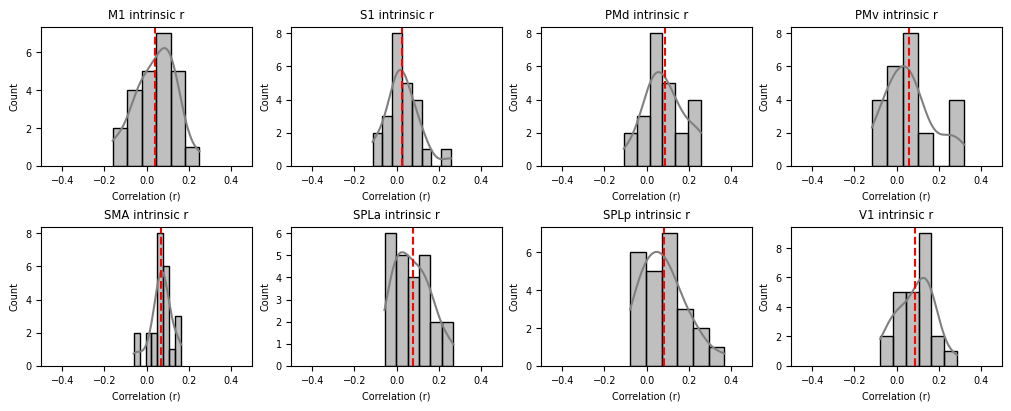

In [17]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y']
    
    N = len(Y)
    r = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12

        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))

        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        # concatenate the contra and ipsi patterns:
        r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])


    r = np.array(r)
    print(f'============== {region} ==============')
    print(f'Mean Pearson r: {np.mean(r):.3f} +/- {stats.sem(r):.3f}')

    # t-test > 0:
    t_stat, p_val = stats.ttest_1samp(r, 0, alternative='greater')
    print(f'T-test > 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.4e}')

    # distribution of r:
    ax = axes.flatten()[regions.index(region)]
    sns.histplot(r, kde=True, color='gray', ax=ax)
    ax.axvline(np.mean(r), color='red', linestyle='--', label='Mean r')
    ax.set_xlabel('Correlation (r)')
    ax.set_ylabel('Count')
    ax.set_title(f'{region} intrinsic r')
    ax.set_xlim(-0.5,0.5)
plt.show()




# Pearson r Extrinsic

============== M1 ==============
Mean Pearson r: 0.014 +/- 0.018
T-test > 0: t(23) = 0.736, p = 2.3456e-01
============== S1 ==============
Mean Pearson r: 0.014 +/- 0.018
T-test > 0: t(23) = 0.766, p = 2.2573e-01
============== PMd ==============
Mean Pearson r: -0.001 +/- 0.016
T-test > 0: t(23) = -0.038, p = 5.1502e-01
============== PMv ==============
Mean Pearson r: 0.016 +/- 0.017
T-test > 0: t(23) = 0.924, p = 1.8251e-01
============== SMA ==============
Mean Pearson r: -0.006 +/- 0.012
T-test > 0: t(23) = -0.547, p = 7.0534e-01
============== SPLa ==============
Mean Pearson r: 0.033 +/- 0.018
T-test > 0: t(23) = 1.880, p = 3.6427e-02
============== SPLp ==============
Mean Pearson r: 0.001 +/- 0.022
T-test > 0: t(23) = 0.048, p = 4.8123e-01
============== V1 ==============
Mean Pearson r: 0.074 +/- 0.022
T-test > 0: t(23) = 3.334, p = 1.4417e-03


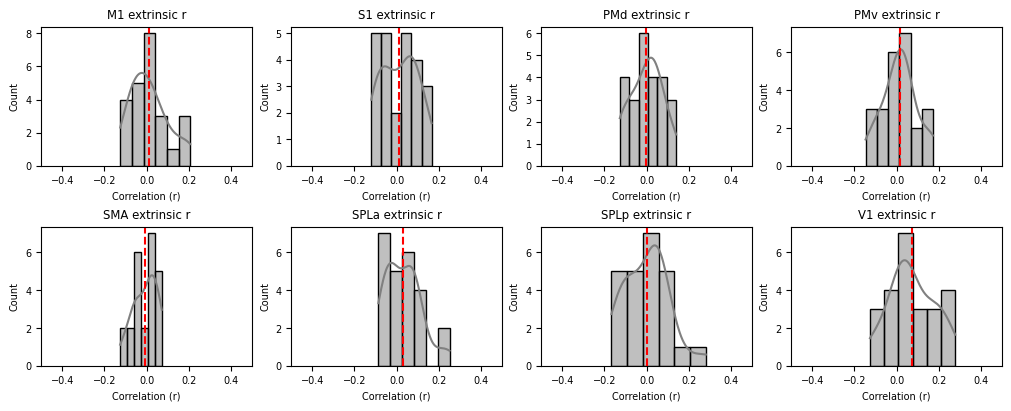

In [18]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)
for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_extrinsic_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y']
    
    N = len(Y)
    r = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12

        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))

        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        # concatenate the contra and ipsi patterns:
        r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])


    r = np.array(r)
    print(f'============== {region} ==============')
    print(f'Mean Pearson r: {np.mean(r):.3f} +/- {stats.sem(r):.3f}')

    # t-test > 0:
    t_stat, p_val = stats.ttest_1samp(r, 0, alternative='greater')
    print(f'T-test > 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.4e}')

    # distribution of r:
    ax = axes.flatten()[regions.index(region)]
    sns.histplot(r, kde=True, color='gray', ax=ax)
    ax.axvline(np.mean(r), color='red', linestyle='--', label='Mean r')
    ax.set_xlabel('Correlation (r)')
    ax.set_ylabel('Count')
    ax.set_title(f'{region} extrinsic r')
    ax.set_xlim(-0.5,0.5)
plt.show()





# PCM Correlation Intrinsic

In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for region in regions:
    # setup the dataset for this analysis:
    datafile = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')
    
    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y'].tolist()

    nsteps = 200 # how many correlation models
    M = []

    # Generate the models
    for r in np.linspace(-1, 1, nsteps):
        M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=6, corr=r, cond_effect=True))

    # Now make the flexible model
    Mflex = pcm.CorrelationModel("flex", num_items=6, corr=None, cond_effect=True)
    M.append(Mflex)

    T, theta = pcm.fit_model_individ(Y, M, fixed_effect='block', fit_scale=False, verbose=False)

    L = T.likelihood.to_numpy()

    # express log-likelihoods relative to mean
    L = L - L.mean(axis=1).reshape(-1,1)
    maxL = L[:,-1] # Last model is the flexible
    L = L[:,0:-1] # Remove it

    # Get the correlation for each of the models
    r = np.empty((nsteps,))
    for i in range(nsteps):
        r[i]= M[i].corr

    # Get the maximum likelihood estimate of each parameter
    maxr = M[-1].get_correlation(theta[-1])
    
    # save results:
    outname = os.path.join(analysisDir, f'pcm_corr_unimanual_intrinsic_{region}.npz')
    np.savez(outname, r=r, L=L, maxr=maxr, maxL=maxL)

    


plot

============== M1 ==============
maxr = 0.300 +/- 0.182
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-1.625; p(23)=0.117749
One-sample t-test maxr vs 0: t(23)=1.645; p=0.113552
============== S1 ==============
maxr = 0.316 +/- 0.180
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-1.603; p(23)=0.122655
One-sample t-test maxr vs 0: t(23)=1.749; p=0.093552
============== PMd ==============
maxr = 0.583 +/- 0.152
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-3.021; p(23)=0.006086
One-sample t-test maxr vs 0: t(23)=3.825; p=0.000868
============== PMv ==============
maxr = 0.347 +/- 0.173
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-2.103; p(23)=0.046580
One-sample t-test maxr vs 0: t(23)=2.010; p=0.056355
============== SMA ==============
maxr = 0.784 +/- 0.117
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-3.032; p(23)=0.005932
One-sample t-test maxr vs 0: t(23)=6.675

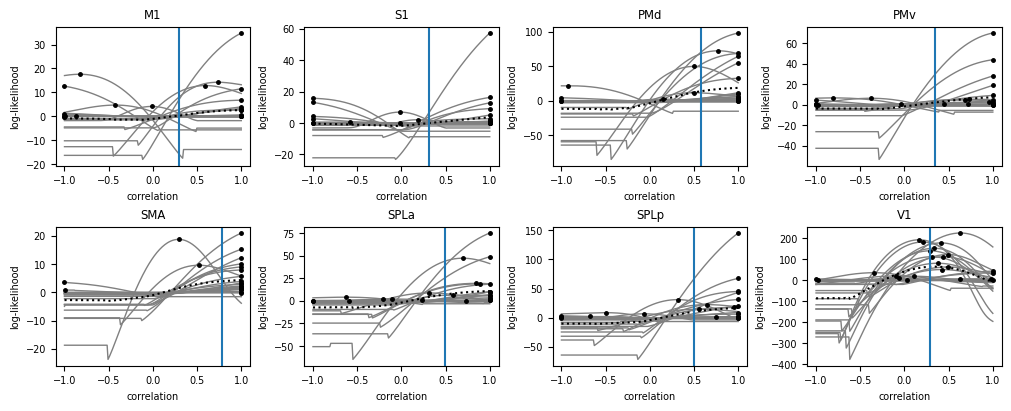

In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(2, len(regions)//2, figsize=(10,4), constrained_layout=True)

for region in regions:
    # load results:
    datafile = os.path.join(analysisDir, f'pcm_corr_unimanual_intrinsic_{region}.npz')
    D = np.load(datafile, allow_pickle=True)
    r = D['r']
    L = D['L']
    maxr = D['maxr']
    maxL = D['maxL']
    print(f'============== {region} ==============')
    print(f'maxr = {np.mean(maxr):.3f} +/- {stats.sem(maxr):.3f}')

    # t-test of r=1 vs 0 
    i1 = 100
    i2 = -1
    print(f"Testing correlation of {r[i1]:0.2f} against {r[i2]:0.2f}")
    t, p = stats.ttest_rel(L[:,i1], L[:,i2], alternative='two-sided')
    print(f'Paired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

    # t-test maxr vs 0:
    t, p = stats.ttest_1samp(maxr, 0, alternative='two-sided')
    print(f'One-sample t-test maxr vs 0: t({len(maxr)-1})={t:1.3f}; p={p:1.6f}')

    # Plot
    ax = axes.flatten()[regions.index(region)]
    ax.plot(r, L.T, color='gray', marker=None, linewidth=1)
    ax.plot(maxr, maxL, 'k.', markersize=5)
    ax.plot(r, L.mean(axis=0), 'k:')
    ax.axvline(maxr.mean())
    ax.set_xlabel('correlation')
    ax.set_ylabel('log-likelihood')
    ax.set_title(f'{region}')

plt.show()




# PCM Correlation Extrinsic sorted

In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for region in regions:
    # setup the dataset for this analysis:
    datafile = os.path.join(analysisDir, f'pcm_dataset_extrinsic_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y'].tolist()

    nsteps = 200 # how many correlation models
    M = []

    # Generate the models
    for r in np.linspace(-1, 1, nsteps):
        M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=6, corr=r, cond_effect=True))

    # Now make the flexible model
    Mflex = pcm.CorrelationModel("flex", num_items=6, corr=None, cond_effect=True)
    M.append(Mflex)

    T, theta = pcm.fit_model_individ(Y, M, fixed_effect='block', fit_scale=False, verbose=False)

    L = T.likelihood.to_numpy()

    # express log-likelihoods relative to mean
    L = L - L.mean(axis=1).reshape(-1,1)
    maxL = L[:,-1] # Last model is the flexible
    L = L[:,0:-1] # Remove it

    # Get the correlation for each of the models
    r = np.empty((nsteps,))
    for i in range(nsteps):
        r[i]= M[i].corr

    # Get the maximum likelihood estimate of each parameter
    maxr = M[-1].get_correlation(theta[-1])

    # save results:
    outname = os.path.join(analysisDir, f'pcm_corr_unimanual_extrinsic_{region}.npz')
    np.savez(outname, r=r, L=L, maxr=maxr, maxL=maxL)




plot

============== M1 ==============
maxr = -0.034 +/- 0.180
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-1.547; p(23)=0.135631
One-sample t-test maxr vs 0: t(23)=-0.188; p=0.852642


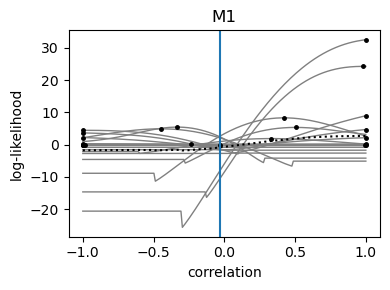

============== S1 ==============
maxr = 0.097 +/- 0.194
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-2.171; p(23)=0.040504
One-sample t-test maxr vs 0: t(23)=0.498; p=0.622883


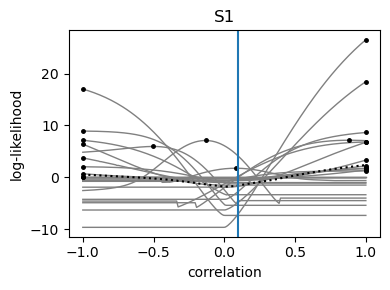

============== PMd ==============
maxr = 0.103 +/- 0.180
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=0.364; p(23)=0.719289
One-sample t-test maxr vs 0: t(23)=0.574; p=0.571642


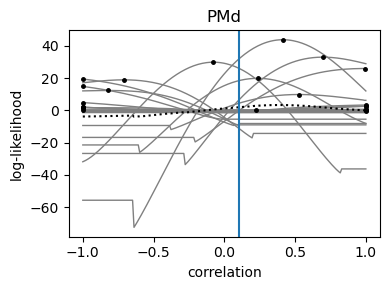

============== PMv ==============
maxr = 0.197 +/- 0.181
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-0.218; p(23)=0.829008
One-sample t-test maxr vs 0: t(23)=1.086; p=0.288787


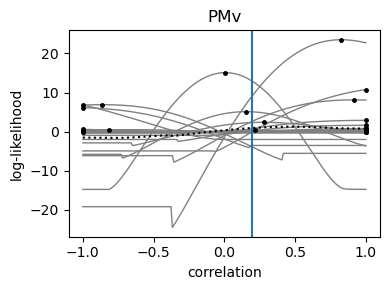

============== SMA ==============
maxr = 0.076 +/- 0.186
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=0.607; p(23)=0.549618
One-sample t-test maxr vs 0: t(23)=0.409; p=0.686633


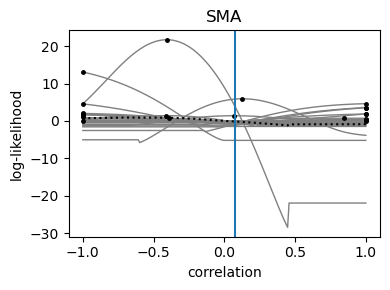

============== SPLa ==============
maxr = 0.281 +/- 0.167
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-1.038; p(23)=0.310001
One-sample t-test maxr vs 0: t(23)=1.684; p=0.105632


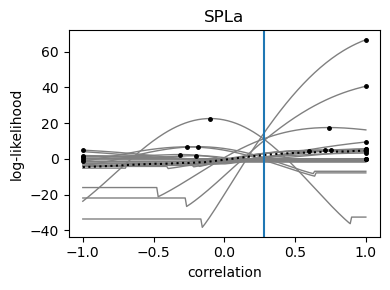

============== SPLp ==============
maxr = 0.126 +/- 0.172
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=-0.518; p(23)=0.609649
One-sample t-test maxr vs 0: t(23)=0.733; p=0.471172


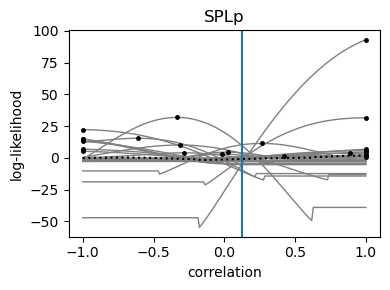

============== V1 ==============
maxr = 0.219 +/- 0.099
Testing correlation of 0.01 against 1.00
Paired-samples t-test: t(23)=2.340; p(23)=0.028307
One-sample t-test maxr vs 0: t(23)=2.222; p=0.036409


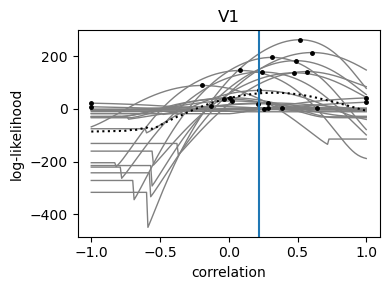

In [150]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']

for region in regions:
    # load results:
    datafile = os.path.join(analysisDir, f'pcm_corr_unimanual_extrinsic_{region}.npz')
    D = np.load(datafile, allow_pickle=True)
    r = D['r']
    L = D['L']
    maxr = D['maxr']
    maxL = D['maxL']
    print(f'============== {region} ==============')
    print(f'maxr = {np.mean(maxr):.3f} +/- {stats.sem(maxr):.3f}')

    # t-test r=1 vs 0
    i1 = 100
    i2 = -1
    print(f"Testing correlation of {r[i1]:0.2f} against {r[i2]:0.2f}")
    t, p = stats.ttest_rel(L[:,i1], L[:,i2], alternative='two-sided')
    print(f'Paired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

    # t-test maxr vs 0:
    t, p = stats.ttest_1samp(maxr, 0, alternative='two-sided')
    print(f'One-sample t-test maxr vs 0: t({len(maxr)-1})={t:1.3f}; p={p:1.6f}')

    # Plot
    plt.figure(figsize=(4,3))
    plt.plot(r, L.T, color='gray', marker=None, linewidth=1)
    plt.plot(maxr, maxL, 'k.', markersize=5, label='Left Hemisphere')
    plt.plot(r, L.mean(axis=0), 'k:')
    plt.axvline(maxr.mean())
    plt.xlabel('correlation')
    plt.ylabel('log-likelihood')
    plt.title(f'{region}')
    plt.tight_layout()
    plt.show()



